In [1]:
import qutip
import numpy as np

from relaqs.api import Gate

## Plot vector of coordinates

In [2]:
def dm_to_3d_coordinates(dm):
    """ Only works for 2x2 """
    a = dm[0][0]
    b = dm[1][0]
    
    x = 2*b.real
    y = 2*b.imag
    z = 2*a.real - 1 # not sure if we can gaurantee that a is real
    
    assert a.imag < 1e-8, "top left entry has non-negligible imaginary component, " \
        "but our code assumes the global phase is such that this element is real."
    
    return x, y, z

def plot_bloch_sphere_vector(x, y, z):
    b = qutip.Bloch()
    vec = [x, y, z]
    b.add_vectors(vec)
    b.show()

1.0 0.0 0.0


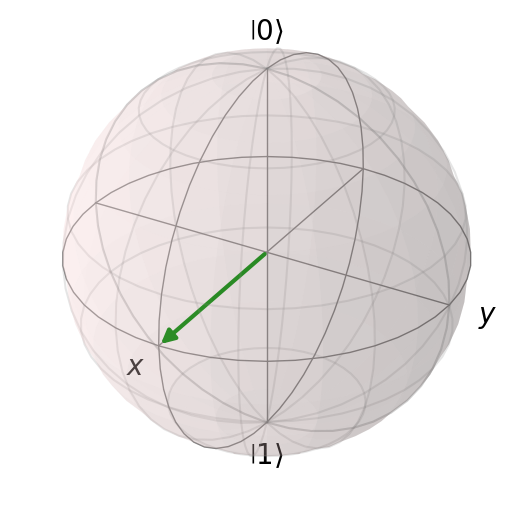

In [3]:
dm = [[0.5, 0.5],
      [0.5, 0.5]]
x, y, z = dm_to_3d_coordinates(dm)
print(x, y, z)
plot_bloch_sphere_vector(x, y, z)

# Plot State

In [4]:
def plot_bloch_sphere_state(state):
    """ State can be a state vector or density matrix """
    qobj = qutip.Qobj(state)
    print(qobj)
    b = qutip.Bloch()
    b.add_states(qobj) # need to convert to Qobj
    b.show()

## Plot state vector 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710678]
 [0.70710678]]


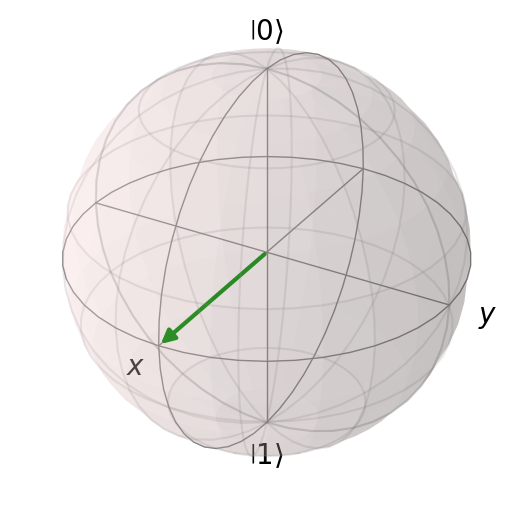

In [5]:
zero = np.array([1, 0]).reshape(-1, 1)
psi = Gate.H @ zero
plot_bloch_sphere_state(psi)

## Plot DM

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


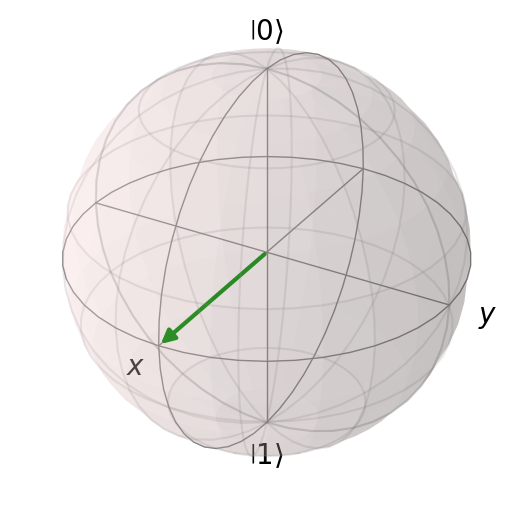

In [6]:
dm = psi @ psi.conjugate().T
plot_bloch_sphere_state(dm)

## Load DM from file

In [7]:
import pandas as pd
from relaqs import RESULTS_DIR

### noiseless

In [8]:
def load_and_plot_noiseless(file_path, use_vector_representation=False):
    # BUG: use_vector_representation=True seems to be bugged 
    df = pd.read_csv(RESULTS_DIR + file_path)
    fidelity = df.iloc[:, 0]
    reward = df.iloc[:, 1]
    actions = df.iloc[:, 2:5]
    unitary = df.iloc[:, 5:]
    
    max_fidelity_idx = fidelity.argmax()
    max_fidelity = fidelity.iloc[max_fidelity_idx]
    best_fidelity_unitary = np.array([complex(x) for x in unitary.iloc[max_fidelity_idx].tolist()]).reshape(2, 2)
    
    print("Max fidelity:", max_fidelity)
    print("Max unitary:", best_fidelity_unitary)
    
    zero = np.array([1, 0]).reshape(-1, 1)
    psi = best_fidelity_unitary @ zero
    
    if use_vector_representation is False:
        plot_bloch_sphere_state(psi)
    else:
        dm = psi @ zero.T.conjugate()
        print("Density Matrix:\n", dm)
        x, y, z = dm_to_3d_coordinates(dm)
        print(x, y, z)
        plot_bloch_sphere_vector(x, y, z)

Max fidelity: 0.9894389288254632
Max unitary: [[ 0.13665274-0.66611908j  0.00945882-0.73315887j]
 [-0.00945882-0.73315887j  0.13665274+0.66611908j]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.13665274-0.66611908j]
 [-0.00945882-0.73315887j]]


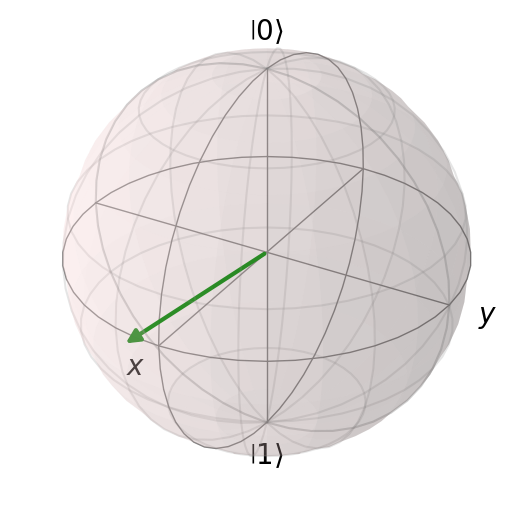

In [9]:
load_and_plot_noiseless('2023-08-02_09-10-09/env_data.csv') # H noiseless

Max fidelity: 0.9999936936479412
Max unitary: [[-0.00162348-0.00273423j -0.00158144-0.99999369j]
 [ 0.00158144-0.99999369j -0.00162348+0.00273423j]]
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.00162348-0.00273423j]
 [ 0.00158144-0.99999369j]]


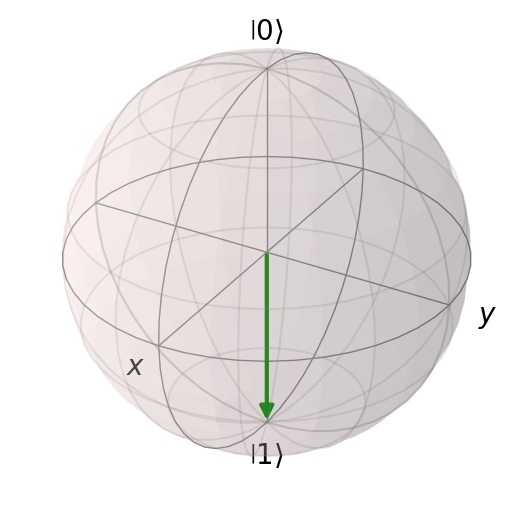

In [10]:
load_and_plot_noiseless('2023-08-02_09-48-04/env_data.csv') # Noiseless X

### noisy

In [11]:
def load_and_plot_noisy(file_path, use_vector_representation=False):
    df = pd.read_csv(RESULTS_DIR + file_path)
    fidelity = df.iloc[:, 0]
    reward = df.iloc[:, 1]
    actions = df.iloc[:, 2:4]
    superoperators = df.iloc[:, 4:]

    max_fidelity_idx = fidelity.argmax()
    max_fidelity = fidelity.iloc[max_fidelity_idx]
    best_fidelity_superoperator = np.array([complex(x) for x in superoperators.iloc[max_fidelity_idx].tolist()]).reshape(4, 4)

    print("Max fidelity:", max_fidelity)
    print("Max unitary:", best_fidelity_superoperator)

    zero = np.array([1, 0]).reshape(-1, 1)
    zero_dm = zero @ zero.T.conjugate()
    zero_dm_flat = zero_dm.reshape(-1, 1)

    dm = best_fidelity_superoperator @ zero_dm_flat
    dm = dm.reshape(2, 2)
    
    if use_vector_representation is False:
        plot_bloch_sphere_state(dm)
    else:
        print("Density Matrix:\n", dm)
        x, y, z = dm_to_3d_coordinates(dm)
        print(x, y, z)
        plot_bloch_sphere_vector(x, y, z)

Max fidelity: 0.4994380234068989
Max unitary: [[ 1.12316021e-03+4.74143152e-20j -4.68067986e-08-1.10446176e-04j
  -4.68067986e-08+1.10446176e-04j  9.98875718e-01-4.43685677e-20j]
 [-3.57463323e-07+8.43476982e-04j  3.74336137e-04+1.08095962e-19j
   9.98126430e-01+8.46006854e-04j -4.51076920e-07+1.06436934e-03j]
 [-3.57463323e-07-8.43476982e-04j  9.98126430e-01-8.46006854e-04j
   3.74336137e-04-1.77737953e-19j -4.51076920e-07-1.06436934e-03j]
 [ 9.98876840e-01+1.34334171e-21j  4.68067986e-08+1.10446176e-04j
   4.68067986e-08-1.10446176e-04j  1.12428215e-03+8.25589626e-20j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.12316021e-03+4.74143152e-20j -3.57463323e-07+8.43476982e-04j]
 [-3.57463323e-07-8.43476982e-04j  9.98876840e-01+1.34334171e-21j]]


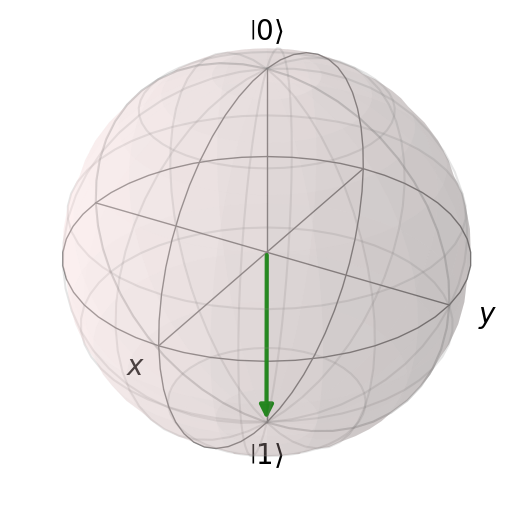

In [12]:
load_and_plot_noisy('2023-07-21_13-34-31/env_data.csv') # H

Max fidelity: 0.9985022162066844
Max unitary: [[ 9.97004018e-01-1.32391015e-23j  6.84863959e-04-9.00410729e-05j
   6.84863959e-04+9.00410729e-05j  4.78579854e-07-4.00797331e-28j]
 [-6.83835892e-04-8.99059099e-05j  9.98500646e-01-3.09097220e-24j
  -4.62085181e-07-1.23640530e-07j  6.85892026e-04+9.01762358e-05j]
 [-6.83835892e-04+8.99059099e-05j -4.62085181e-07+1.23640530e-07j
   9.98500646e-01+9.70841689e-24j  6.85892026e-04-9.01762358e-05j]
 [ 2.99598212e-03+1.05997870e-23j -6.84863959e-04+9.00410729e-05j
  -6.84863959e-04-9.00410729e-05j  9.99999521e-01-1.05875097e-23j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 9.97004018e-01-1.32391015e-23j -6.83835892e-04-8.99059099e-05j]
 [-6.83835892e-04+8.99059099e-05j  2.99598212e-03+1.05997870e-23j]]


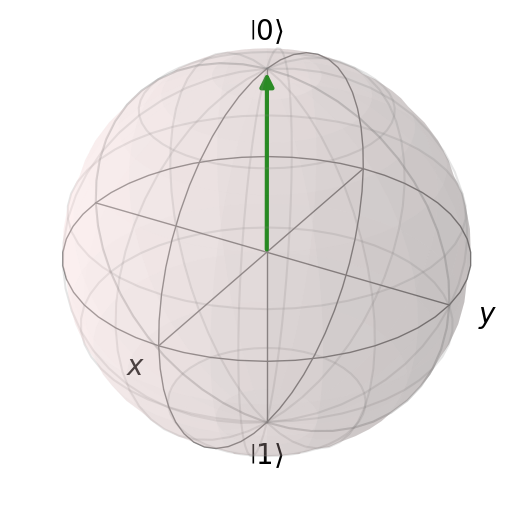

In [13]:
load_and_plot_noisy('2023-07-25_22-32-31/env_data.csv') # X pi/4

Max fidelity: 0.9985015419432878
Max unitary: [[ 1.12325327e-03+7.91357237e-21j  1.31164600e-09-2.27261488e-05j
   1.31164600e-09+2.27261488e-05j  9.98875792e-01-2.09292794e-21j]
 [ 5.37412219e-08+9.31143773e-04j  3.74303486e-04-4.50689357e-21j
   9.98126814e-01-1.15214334e-04j  5.63645139e-08+9.76596071e-04j]
 [ 5.37412219e-08-9.31143773e-04j  9.98126814e-01+1.15214334e-04j
   3.74303486e-04-1.00472646e-20j  5.63645139e-08-9.76596071e-04j]
 [ 9.98876747e-01-5.63527972e-21j -1.31164600e-09+2.27261488e-05j
  -1.31164600e-09-2.27261488e-05j  1.12420756e-03+2.63306415e-21j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.12325327e-03+7.91357237e-21j 5.37412219e-08+9.31143773e-04j]
 [5.37412219e-08-9.31143773e-04j 9.98876747e-01-5.63527972e-21j]]


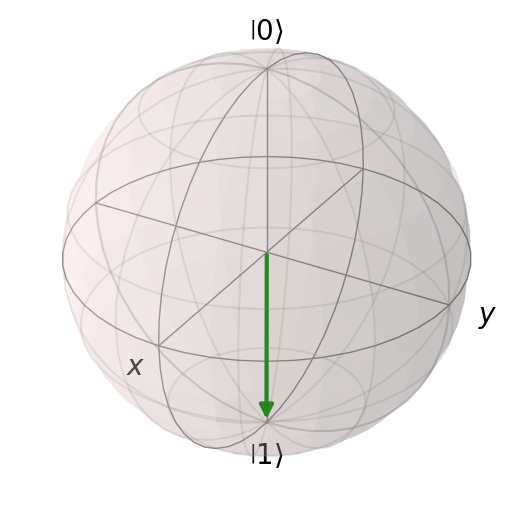

In [14]:
load_and_plot_noisy("2023-07-26_13-14-26/env_data.csv") # X